## DenseNet121 + CBAM

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

2025-07-01 16:24:03.887907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751387044.109910      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751387044.170766      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'  # Update path if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224  
BATCH_SIZE = 32
NUM_CLASSES = 5

In [3]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_gen   = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 115241 images belonging to 5 classes.
Found 14227 images belonging to 5 classes.
Found 14201 images belonging to 5 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, InceptionV3, Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Your CBAM layer from earlier (must match model you're loading/saving)
class CBAM(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_dense_one = layers.Dense(channel // self.ratio, activation='relu',
                                             kernel_initializer='he_normal', use_bias=True)
        self.shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
        self.conv_spatial = layers.Conv2D(filters=1, kernel_size=7, padding='same',
                                          activation='sigmoid', kernel_initializer='he_normal', use_bias=False)

    def call(self, input_feature):
        # Channel Attention
        avg_pool = tf.reduce_mean(input_feature, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(input_feature, axis=[1, 2], keepdims=True)
        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        channel_attention = tf.nn.sigmoid(avg_out + max_out)
        x = input_feature * channel_attention

        # Spatial Attention
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv_spatial(concat)
        return x * spatial_attention

In [5]:
base_model = DenseNet121(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = CBAM()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_densenet = models.Model(inputs, outputs)
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_densenet.summary()

I0000 00:00:1751387145.333742      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751387145.334517      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cbam (CBAM)                          │ (None, 7, 7, 1024)          │         263,394 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,310,119 (27.89 MB)

 Trainable params: 7,224,423 (27.56 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint('/kaggle/working/best_densenet121_cbam.h5',
                                save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')

history = model_densenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751387240.509284      84 service.cc:148] XLA service 0x7f732c002c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751387240.510395      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751387240.510416      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751387249.337197      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751387338.832910      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1574s 384ms/step - accuracy: 0.5117 - loss: 1.3205 - val_accuracy: 0.5652 - val_loss: 1.1900 - learning_rate: 0.0010
Epoch 2/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1213s 337ms/step - accuracy: 0.5599 - loss: 1.1733 - val_accuracy: 0.4665 - val_loss: 1.3145 - learning_rate: 0.0010
Epoch 3/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1214s 337ms/step - accuracy: 0.5859 - loss: 1.0963 - val_accuracy: 0.6364 - val_loss: 0.9742 - learning_rate: 0.0010
Epoch 4/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1217s 338ms/step - accuracy: 0.6270 - loss: 0.9831 - val_accuracy: 0.6046 - val_loss: 1.0277 - learning_rate: 0.0010
Epoch 5/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1218s 338ms/step - accuracy: 0.6539 - loss: 0.9204 - val_accuracy: 0.6353 - val_loss: 1.4597 - learning_rate: 0.0010
Epoch 6/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1216s 337ms/step - accuracy: 0.6871 - loss: 0.8342 - val_accuracy: 0.7084 - val_loss: 0.8293 - learning_rate: 2.0000e-04
Epoch 7/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1210s 336ms

In [7]:
import pickle

# Save history to disk
with open("DenseNet_Cbam_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

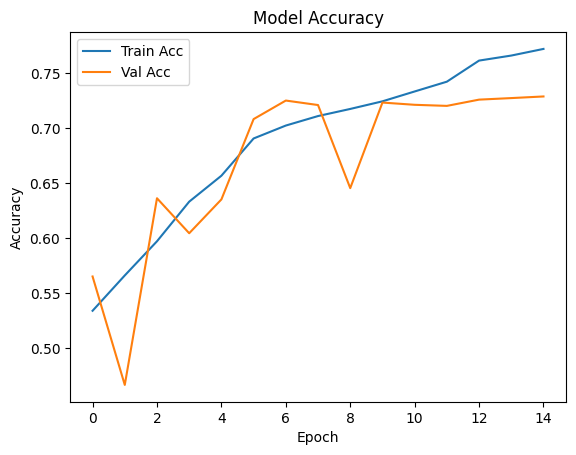

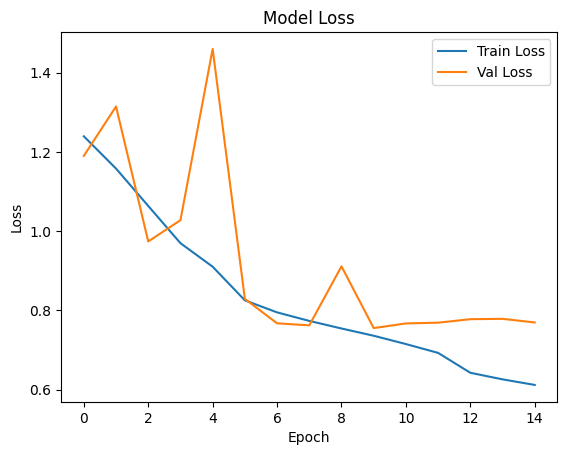

In [8]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

444/444 ━━━━━━━━━━━━━━━━━━━━ 165s 348ms/step
              precision    recall  f1-score   support

           0     0.7943    0.9617    0.8700      6896
           1     0.3460    0.4581    0.3943      1862
           2     0.4222    0.1881    0.2602      2999
           3     0.3650    0.2198    0.2744       978
           4     0.5749    0.5730    0.5740      1466

    accuracy                         0.6411     14201
   macro avg     0.5005    0.4801    0.4746     14201
weighted avg     0.6047    0.6411    0.6073     14201



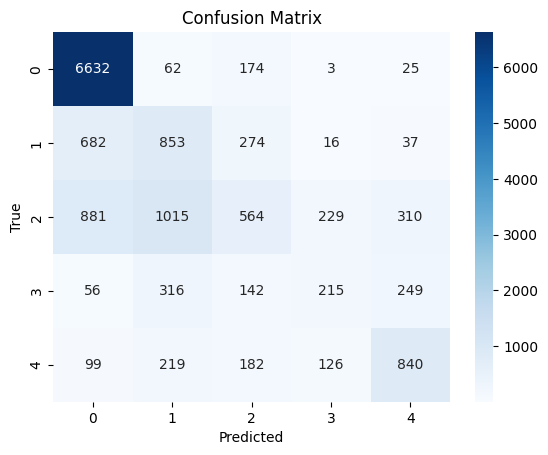

Quadratic Weighted Kappa (QWK): 0.7132


In [9]:
y_true = test_gen.classes
y_pred_probs = model_densenet.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")